In [ ]:
# default_exp datasets

## Dataset Class

This class reads in a dataset and does the necessary preprocessing for a pytorch model.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# EXPORT
#from torchvision import datasets, transforms
import os, sys
from glob import glob
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm

## MantaFlow

In [ ]:
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200'

In [ ]:
files = glob(os.path.join(dataDirec,'v','*.npz'))
files

In [ ]:
# EXPORT
def loadfile(fn):
    A = np.load(fn)
    X = A['x'].astype('float32')
    X = np.rollaxis(X,-1)
    y = A['y'].astype('float32')
    return X,y

In [ ]:
X,y = loadfile(files[100])
X.shape, y.shape

In [ ]:
# EXPORT
class MantaFlowDataset(Dataset):
    def __init__(self, 
                 dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                 numToKeep=np.infty,transform=None, reverseXY=False, preprocess=True, AE=False): 
        if type(dataDirec) == list:
            self.files = dataDirec
        else:
            self.files = glob(os.path.join(dataDirec,'*.npz'))
        self.dataDirec = dataDirec
        self.numToKeep = numToKeep
        self.transform = transform
        self.reverseXY = reverseXY
        self.AE = AE
        self.data = []
 
        if numToKeep < len(self.files):
            self.files = self.files[:numToKeep]
        for f in tqdm(self.files):
            X,y = self.loadfile(f)
            
            if preprocess:
                X,y = self.preprocessFcn(X,y)
                
            if reverseXY:
                self.data.append((y,X))
            else:
                self.data.append((X,y))

    def loadfile(self,fn):
        A = np.load(fn)
        X = A['x'].astype('float32')
        X = np.rollaxis(X,-1)
        y = A['y'].astype('float32')
        return X,y

    def preprocessFcn(self,X,y):
        x_range = 11.953
        X /= x_range
        y_range = [[0.2, 0.8], [0.04, 0.12], [0.0, 199.0]]
        for i, ri in enumerate(y_range):
            y[i] = (y[i]-ri[0]) / (ri[1]-ri[0]) * 2 - 1
        return X,y
    
    def __len__(self):
        return len(self.data)

    def plot(self,idx,savefig=False):
        X, label  = self.data[idx]
        if self.reverseXY:
            X = label
            
        plt.figure(figsize=(20,10))
        
        plt.subplot(211)
        fn = self.files[idx].replace('.npz','')
        title = '{} channel 0'.format(fn)
        plt.title(title)
        plt.imshow(X[0][::-1])
        plt.colorbar()
        
        plt.subplot(212)
        title = '{} channel 1'.format(fn)
        plt.title(title)
        plt.imshow(X[1][::-1])
        plt.colorbar()
        
        if savefig:
            title = title.replace(' ','_') + '.png'
            plt.savefig(title, dpi=300)
            plt.close()
        else:
            plt.show()

    def __getitem__(self, idx):
        X, y  = self.data[idx]
        if self.transform:
            X = self.transform(X)
        if self.AE:
            return X, X # looks crazy, but it's dirty fix to allow lr_finder to work 
        return X, y

In [ ]:
M = MantaFlowDataset(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                 numToKeep=100)

In [ ]:
M = MantaFlowDataset(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v')

In [ ]:
M.plot(54)

In [ ]:
M.plot(54,savefig=True)

In [ ]:
bz = 16
dataLoader = DataLoader(M,batch_size=bz,shuffle=True)

In [ ]:
X,y = next(iter(dataLoader))

In [ ]:
X.shape
X.dtype

In [ ]:
y.shape
y.dtype

In [ ]:
# M = MantaFlowDataset(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
#                  numToKeep=np.infty)

In [ ]:
dataLoader = DataLoader(M,batch_size=bz,shuffle=True)

In [ ]:
cnt = 1
for batch in dataLoader:
    cnt += 1

In [ ]:
cnt

In [ ]:
MfromList = MantaFlowDataset(files,numToKeep=100)

In [ ]:
MfromList.plot(54)

In [ ]:
MfromList = MantaFlowDataset(files,numToKeep=100,reverseXY=True)

In [ ]:
MfromList.plot(3)

In [ ]:
dataLoader = DataLoader(MfromList,batch_size=bz)

In [ ]:
a,b = next(iter(dataLoader))
a.shape
b.shape

In [ ]:
M = MantaFlowDataset(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                 numToKeep=100, AE=True)

In [ ]:
A,B = M[10]

In [ ]:
X,p = A
X.shape, p.shape

In [ ]:
B.shape

In [ ]:
M.plot(10)

In [ ]:
# EXPORT
import os
from glob import glob

def getSingleSim(sim,
                 dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                 simLen=200):
    if type(dataDirec) == str:
        data = glob(os.path.join(dataDirec,'*.npz'))
    else:
        data = dataDirec
    data = sorted(data)
    out = data[sim*simLen:(sim+1)*simLen]
    order = []
    for fn in out:
        a = os.path.basename(fn).replace('.npz','').split('_')
        order.append(int(a[2]))
    sorted_idx = np.argsort(order)
    out = [out[i] for i in sorted_idx]
    return out


def createMantaFlowTrainTest(dataDirec='/home/widemann1/carbon_capture/surrogate_nn_for_pde/deep-fluids/data/smoke_pos21_size5_f200/v',
                            simLen=200,
                            testSplit=.1,
                            seed=1234):
    data = glob(os.path.join(dataDirec,'*.npz'))
    data = sorted(data)
    numSims = len(data)//simLen
    numTestSamples = int(np.round(testSplit*numSims))
    np.random.seed(seed)
    perm = np.random.permutation(numSims)
    testSims = perm[:numTestSamples]
    trainSims = perm[numTestSamples:]
    
    def _getSimFrames(data, sim=0,simLen=200):
        out = data[sim*simLen:(sim+1)*simLen]
        order = []
        for fn in out:
            a = os.path.basename(fn).replace('.npz','').split('_')
            order.append(int(a[2]))
        sorted_idx = np.argsort(order)
        out = [out[i] for i in sorted_idx]
        return out
    
    def _buildDataset(simData, sims, simLen):
        data = []
        for i in sims:
            sim = _getSimFrames(simData, i, simLen)
            data.append(sim)
        data = [i for sublist in data for i in sublist]
        return data
    
    testData = _buildDataset(data, testSims, simLen)
    trainData = _buildDataset(data, trainSims, simLen)
    return trainData, testData

In [ ]:
tr, te = createMantaFlowTrainTest()
te

In [ ]:
singleTestSim = getSingleSim(sim=5)
singleTestSim

In [ ]:
singleTestSim = getSingleSim(sim=5,dataDirec=te)
singleTestSim

In [ ]:
MantaFlowDataset(tr,numToKeep=1000)

## PNNL Time Step Data

In [ ]:
# EXPORT 
import pandas as pd
from scipy.interpolate import interp2d, griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re

In [ ]:
# each sim is broken into two directories 'a' and 'b'
dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
sims = ['001','025','050']
simIdx = 0
files = []
for i in ['a','b']:
    pth = os.path.join(dataDirec,sims[simIdx] + i)
    files.append(glob(os.path.join(pth,'*.csv')))
files = [i for sublist in files for i in sublist]
len(files)

500

In [ ]:
# EXPORT
def getInt(f):
    return int(f.split('_')[-1].replace('.csv',''))

In [ ]:
L = np.argsort(list(map(getInt,files)))
L

array([  0, 112, 173, 184, 195, 206, 217, 228, 239,   1,  12,  24,  35,
        46,  57,  23,  79,  90, 101, 113, 124, 135,  71, 156, 163, 169,
       170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  72,  73,  74,  75,  76,  77,  78,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  91,  9

In [ ]:
orderedFiles = [files[i] for i in L]
orderedFiles

['/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_10.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_20.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_30.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_40.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_50.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_60.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_70.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_80.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_90.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_100.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_110.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_120.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_130.csv',
 '/data/ccsi/PNNLTimeStepData/rars

### PNNL Dataset Class

In [ ]:
# EXPORT
def plotData(grid_x, grid_y, grid_z, title, pngFile=None):
    plt.figure()
    ax = plt.gca()
    im = ax.pcolormesh(grid_y,grid_x, grid_z, cmap='RdYlBu')
    plt.axes().set_aspect('equal')
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    if pngFile:
        plt.savefig(pngFile, dpi=300)
        plt.close()
        
def interpData(x,y,z,Nx=None,Ny=None,delta_x=None,nextPow2=False):
    '''
    This function takes 3 lists of points (x,y,z) and maps them to a 
    rectangular grid. Either Nx or Ny must be set or delta_x must be set. 
    e.g. 
    
    x = y = z = np.random.rand(30)
    grid_x, grid_y, grid_z = interpData(x,y,z,Nx=128,Ny=128)
    
    or 
    
    grid_x, grid_y, grid_z = interpData(x,y,z,delta_x=1e-3,nextPow2=True)
    '''
    
    eps = 1e-4 # needed to make sure that the interpolation does not have nans. 
    def _NextPowerOfTwo(number):
        # Returns next power of two following 'number'
        return np.ceil(np.log2(number))
    
    if Nx == None and Ny == None:
        assert delta_x != None
        delta_y = delta_x
        Nx = int((x.max() - x.min())/delta_x)
        Ny = int((y.max() - y.min())/delta_y)

    if nextPow2:
        Nx = 2**_NextPowerOfTwo(Nx)
        Ny = 2**_NextPowerOfTwo(Ny)
        
    grid_x, grid_y = np.mgrid[x.min()+eps:x.max()-eps:Nx*1j,y.min()+eps:y.max()-eps:Ny*1j]
    grid_z = griddata(np.array([x,y]).T, z, (grid_x, grid_y), method='cubic')
    return grid_x, grid_y, grid_z

def plotFrame(fn):
    D = pd.read_csv(fn)
    x = D['X (m)']
    y = D['Y (m)']
    for d in D.columns[:4]:
        z = D[d]
        grid_x, grid_y, grid_z = interpData(x.values,y.values,z.values,delta_x=1e-4)
        idx = getInt(fn)
        d = d.replace(' ','_')
        d = re.sub(r'[^A-Za-z0-9 ]+', '_', d)[:-1]
        title = '{}, Time Step: {}'.format(d,idx)
        pngFile = '{}_{}.png'.format(d,idx)
        plotData(grid_y, grid_x, grid_z, title, pngFile)


In [ ]:
D = pd.read_csv(orderedFiles[0])
x = D['X (m)']
y = D['Y (m)']
vj = D['Velocity[j] (m/s)']

In [ ]:
grid_x, grid_y, grid_z = interpData(x.values,y.values,vj.values,Nx=512,Ny=512)
grid_x.shape, grid_y.shape, grid_z.shape

((512, 512), (512, 512), (512, 512))

In [ ]:
len(x), grid_x.size # the original dataset vs. interpolated

(150073, 262144)

In [ ]:
grid_x, grid_y, grid_z = interpData(x.values,y.values,vi.values,delta_x=1e-3,nextPow2=True)
grid_x.shape, grid_y.shape, grid_z.shape

((128, 128), (128, 128), (128, 128))

In [ ]:
len(x), grid_x.size # the original dataset vs. interpolated

(150073, 16384)

/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


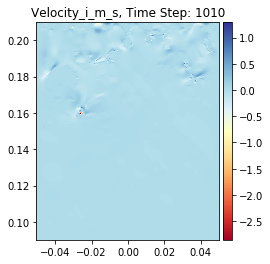

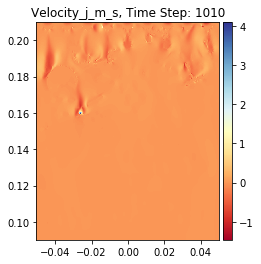

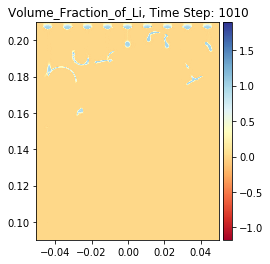

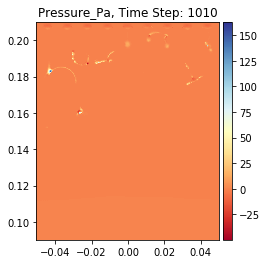

In [ ]:
plotFrame(orderedFiles[100])

In [ ]:
# EXPORT
class CCSI_2D(Dataset):
    def __init__(self, 
                 dataDirec='/data/ccsi/PNNLTimeStepData/001a/',
                 numToKeep=np.infty,transform=None,preprocess=None,
                 Nx=None,Ny=None,delta_x=None,nextPow2=True): 
        
        self.data = []
        self.files = []
        self.delta_x = delta_x
        self.nextPow2 = nextPow2
        self.Nx = Nx
        self.Ny = Ny
        self.grid_x = []
        self.grid_y = []
        self.preprocess = preprocess
        
        if type(dataDirec) == list:
            self.files = dataDirec
        elif 'pkl' in dataDirec:
            with open(dataDirec,'rb') as fid:
                D = pickle.load(fid)
                self.data = np.array(D['data'])
                self.grid_x = D['grid_x']
                self.grid_y = D['grid_y']
                if numToKeep < len(self.data):
                     self.data = self.data[:numToKeep]
        else:
            files = glob(os.path.join(dataDirec,'*.csv'))       
            L = np.argsort(list(map(getInt,files)))
            self.files = [files[i] for i in L]
            
        self.dataDirec = dataDirec
        self.numToKeep = numToKeep
        self.transform = transform
        self.preprocess = preprocess
        self.column = []

        
        if self.files is not []:
            if numToKeep < len(self.files):
                self.files = self.files[:numToKeep]

            for f in self.files:
                self.data.append(self.loadfile(f)) 
                
        if preprocess:
            for i,d in enumerate(self.data):
                self.data[i] = preprocess(d)

    def loadfile(self,fn):
        D = pd.read_csv(fn)
        x = D['X (m)'].values.astype('float32')
        y = D['Y (m)'].values.astype('float32')
        X = []
        for d in D.columns[:4]:
            z = D[d].values.astype('float32')
            grid_x, grid_y, grid_z = interpData(x,y,z,
                                                self.Nx,self.Ny,
                                                self.delta_x,self.nextPow2)
            X.append(grid_z)
            
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.column = D.columns[:4]
        return np.array(X).astype('float32')

# this is the mantaflow one. Our's should be similar 
#     def preprocessFcn(self,X,y):
#         x_range = 11.953
#         X /= x_range
#         y_range = [[0.2, 0.8], [0.04, 0.12], [0.0, 199.0]]
#         for i, ri in enumerate(y_range):
#             y[i] = (y[i]-ri[0]) / (ri[1]-ri[0]) * 2 - 1
#         return X,y
    
    def __len__(self):
        return len(self.data)


    def plotData(self,idx,pngFile=None):
        D = self.data[idx]
        for i in range(4):
            grid_z = D[i]
            plt.figure()
            ax = plt.gca()
            im = ax.pcolormesh(self.grid_x,self.grid_y, grid_z, cmap='RdYlBu')
            plt.axes().set_aspect('equal')
            plt.title('Sample {}, {}'.format(idx,self.column[i]))
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            if pngFile:
                plt.savefig(pngFile, dpi=300)
                plt.close()

    def __getitem__(self, idx):
        X  = self.data[idx].astype('float32')
        if self.transform is not None:
            X = self.transform(X)
        return X,X # this allows LR_finder to work

### Test the CCSI_2D class

In [ ]:
D = CCSI_2D(orderedFiles,Nx=128,Ny=128,numToKeep=1)

100%|██████████| 1/1 [00:16<00:00, 16.72s/it]


In [ ]:
np.any(np.isnan(D.data))

False

/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


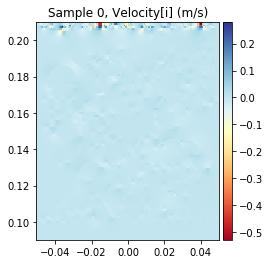

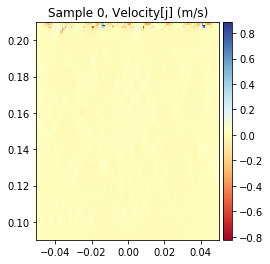

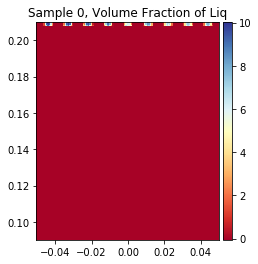

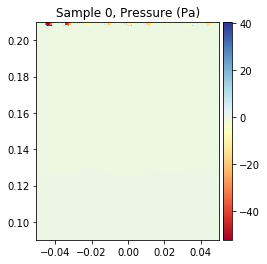

In [ ]:
D.plotData(0)

In [ ]:
D = CCSI_2D(orderedFiles,delta_x=1e-4,nextPow2=True,numToKeep=1)

100%|██████████| 1/1 [00:23<00:00, 23.45s/it]


False


/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


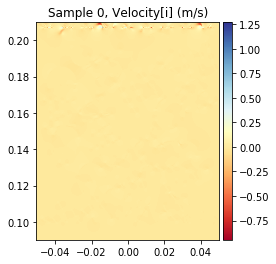

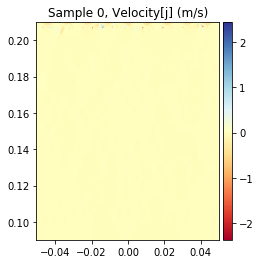

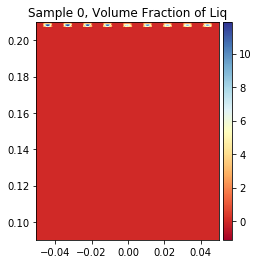

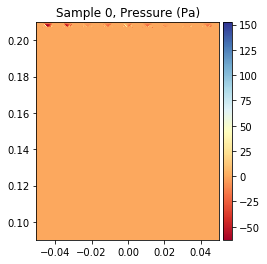

In [ ]:
print(np.any(np.isnan(D.data)))
D.plotData(0)

### Create the 128x128 dataset

In [ ]:
# D = CCSI_2D(orderedFiles,Nx=128,Ny=128) # takes 1.5 hours
# data = {'grid_x':D.grid_x, 'grid_y': D.grid_y, 'data':D.data}
# s = os.path.join('/data/ccsi/PNNLTimeStepData/data_128x128',sims[simIdx] + '.pkl')
# with open(s,'wb') as fid:
#     pickle.dump(data,fid)

### Read in the saved dataset above

In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128/025.pkl')
len(D)

0it [00:00, ?it/s]


500

### Create the preprocessing function

In [ ]:
dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
sims = ['001','025','050']

files = []
for s in sims:
    for i in ['a','b']:
        pth = os.path.join(dataDirec,s + i)
        files.append(glob(os.path.join(pth,'*.csv')))
files = [i for sublist in files for i in sublist]
len(files)

1500

In [ ]:
x = D.max().values
x.shape

(7,)

In [ ]:
mx = -100*np.zeros((1,n))
mx.shape

(1, 4)

In [ ]:
n = 4
mx = -100*np.zeros((1,n))
mn = 100*np.zeros((1,n))
for f in files:
    D = pd.read_csv(f)
    
    M = D.max().values[:4].reshape(1,n)
    out = np.concatenate([mx,M])
    mx = np.max(out,axis=0).reshape(1,n)
    
    m = D.min().values[:4].reshape(1,n)
    out = np.concatenate([mn,m])
    mn = np.min(out,axis=0).reshape(1,n)

print(mx,mn)

[[5.45737743e+00 4.04774484e+00 1.00000000e+00 2.01130242e+03]] [[   -4.78789294    -8.71334335     0.         -1724.7904391 ]]


In [ ]:
mn

array([[   -4.78789294,    -8.71334335,     0.        , -1724.7904391 ]])

In [ ]:
# EXPORT
def preprocess(X,mx=[5.46,4.1,1.,2012.],
                 mn=[-4.8, -8.8,0.,-1725.]):
    Xnew = np.empty_like(X)
    cnt = 0
    for x,M,m in zip(X,mx,mn):
        Xnew[cnt] = (x-m)/(M-m)
        cnt += 1
    return Xnew


In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128/025.pkl')
out = preprocess(D.data[0])
out.shape

0it [00:00, ?it/s]


(4, 128, 128)

In [ ]:
for d in D.data:
    out = preprocess(d)
    for i in range(4):
        print(out[i].max(),out[i].min())
    print('')

0.50293183 0.40203586
0.85460436 0.57009786
4.5316043 -0.032396875
0.4657295 0.4571631

0.5106883 0.39424932
0.83643687 0.58261365
1.6270082 -0.08443091
0.46279654 0.4593187

0.51522493 0.3667063
0.8339875 0.5897005
1.1215632 -0.07695015
0.4627229 0.45797414

0.51658636 0.39951286
0.8336143 0.5913162
1.0563834 -0.04695633
0.46225372 0.45876986

0.5689923 0.3956231
0.83666414 0.59403867
0.96489096 -0.04485768
0.46221977 0.45921308

0.58752626 0.36591282
0.84169585 0.58816737
1.0156589 -0.044720136
0.46213567 0.4597381

0.57829463 0.36580822
0.85001314 0.5879859
1.032437 -0.048868436
0.46228388 0.45988122

0.55246514 0.3757527
0.85565627 0.5974938
1.0261949 -0.060214296
0.4621955 0.4599472

0.5481788 0.36615205
0.84895283 0.594645
1.0258528 -0.07893526
0.4621195 0.45991582

0.5563171 0.3847038
0.84571636 0.59396625
1.0332466 -0.077378914
0.46207935 0.45980003

0.53645605 0.39238983
0.8418929 0.59496355
1.0251653 -0.07188402
0.4621778 0.45971864

0.5371689 0.39463487
0.8376505 0.5917726
1

1.0679286 -0.10985502
0.5313151 0.44843647

0.657786 0.30887085
0.82681364 0.5769603
1.0667062 -0.10170749
0.51262337 0.451246

0.65901893 0.35872096
0.8357279 0.5864586
1.0675011 -0.099260285
0.51236874 0.44968787

0.6692482 0.34059143
0.84881455 0.57573533
1.0618469 -0.10902223
0.51253664 0.44760272

0.6615428 0.3078926
0.8620242 0.54764277
1.0527525 -0.07399935
0.5126377 0.43655416

0.6655174 0.3637337
0.8735078 0.5454105
1.0809743 -0.09332382
0.5270205 0.4404298

0.6662934 0.3631353
0.8408709 0.5515171
1.0553379 -0.12283815
0.5238464 0.44157365

0.6439762 0.26717335
0.81035644 0.55529
1.0853165 -0.13290693
0.5139648 0.44577807

0.61810714 0.12784947
0.8255456 0.5667179
1.1168864 -0.09778398
0.5145527 0.44755667

0.5915628 0.2139323
0.8291892 0.5568132
1.1099186 -0.14961432
0.5150706 0.44790426

0.5883297 0.28091833
0.8134266 0.54441816
1.0540316 -0.15240058
0.5155146 0.4492653

0.60556614 0.193001
0.8150754 0.5492563
1.0521123 -0.13688798
0.5158085 0.4502787

0.57004535 0.28229707


0.5184186 0.4131652

0.53644186 0.33878902
0.870057 0.495578
1.0904683 -0.12642607
0.51786333 0.41659445

0.5797357 0.33168098
0.8509883 0.5550298
1.0876212 -0.13265204
0.51724565 0.4116664

0.5951204 0.33244836
0.8353162 0.51408106
1.09294 -0.12680173
0.516948 0.41370183

0.6421415 0.30026206
0.7803756 0.5095096
1.1097044 -0.15782589
0.5169271 0.4162909

0.57049465 0.29713467
0.83894914 0.56301624
1.0782893 -0.13207252
0.51647604 0.41567725

0.5699437 0.30874825
0.8432348 0.5306494
1.075165 -0.14563695
0.5162187 0.4160237

0.5599207 0.32079548
0.83702207 0.5782104
1.0723215 -0.12766358
0.51597774 0.4156756

0.61626846 0.32444015
0.82289815 0.51218265
1.0777205 -0.17687835
0.5127423 0.41620594

0.5569026 0.3265808
0.8217927 0.57018816
1.0813652 -0.20075929
0.54753506 0.41577294

0.56320614 0.3291731
0.8242012 0.5535322
1.0764091 -0.17959736
0.51708436 0.41757545

0.6610981 0.3323046
0.82151216 0.54950225
1.086252 -0.16592246
0.5172783 0.41859886

0.6726938 0.33303374
0.8149725 0.547570

0.62278044 0.2843682
0.8419241 0.5654269
1.0818417 -0.17206281
0.5148333 0.43007714

0.5941178 0.2777374
0.8234722 0.579912
1.1103162 -0.17227331
0.5189321 0.43080384

0.56084347 0.26772627
0.8136621 0.5843973
1.0756155 -0.1569087
0.51477706 0.4319609

0.5498092 0.29369766
0.8151229 0.58492875
1.0805382 -0.16007617
0.5122181 0.4289083

0.6577212 0.27883008
0.8208202 0.5928784
1.0858848 -0.14775212
0.5163219 0.4278723

0.5609346 0.28829673
0.8205219 0.5562744
1.082453 -0.14107533
0.5145698 0.42905053

0.58440554 0.3656543
0.8165439 0.57766086
1.0819864 -0.13826771
0.5145919 0.42910713

0.5570773 0.37178743
0.8166397 0.5769151
1.0786319 -0.14016052
0.5130259 0.42772108

0.65054893 0.38061073
0.8108822 0.58582264
1.0756131 -0.19120106
0.5149338 0.428661

0.63435006 0.36686787
0.815612 0.47678706
1.1244347 -0.22569206
0.5165814 0.42869815

0.6076776 0.3987138
0.8185736 0.5011946
1.0930213 -0.13672331
0.5148825 0.42782956

0.58647686 0.3900362
0.8206517 0.50972867
1.090667 -0.13358623
0.513

In [ ]:
x.max(),x.min()

(0.36008012, -0.67511207)

In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128/025.pkl', preprocess=preprocess)

In [ ]:
for d in D.data:
    for i in range(4):
        print(d[i].max(),d[i].min())
    print('')

0.50293183 0.40203586
0.85460436 0.57009786
4.5316043 -0.032396875
0.4657295 0.4571631

0.5106883 0.39424932
0.83643687 0.58261365
1.6270082 -0.08443091
0.46279654 0.4593187

0.51522493 0.3667063
0.8339875 0.5897005
1.1215632 -0.07695015
0.4627229 0.45797414

0.51658636 0.39951286
0.8336143 0.5913162
1.0563834 -0.04695633
0.46225372 0.45876986

0.5689923 0.3956231
0.83666414 0.59403867
0.96489096 -0.04485768
0.46221977 0.45921308

0.58752626 0.36591282
0.84169585 0.58816737
1.0156589 -0.044720136
0.46213567 0.4597381

0.57829463 0.36580822
0.85001314 0.5879859
1.032437 -0.048868436
0.46228388 0.45988122

0.55246514 0.3757527
0.85565627 0.5974938
1.0261949 -0.060214296
0.4621955 0.4599472

0.5481788 0.36615205
0.84895283 0.594645
1.0258528 -0.07893526
0.4621195 0.45991582

0.5563171 0.3847038
0.84571636 0.59396625
1.0332466 -0.077378914
0.46207935 0.45980003

0.53645605 0.39238983
0.8418929 0.59496355
1.0251653 -0.07188402
0.4621778 0.45971864

0.5371689 0.39463487
0.8376505 0.5917726
1

0.5145527 0.44755667

0.5915628 0.2139323
0.8291892 0.5568132
1.1099186 -0.14961432
0.5150706 0.44790426

0.5883297 0.28091833
0.8134266 0.54441816
1.0540316 -0.15240058
0.5155146 0.4492653

0.60556614 0.193001
0.8150754 0.5492563
1.0521123 -0.13688798
0.5158085 0.4502787

0.57004535 0.28229707
0.837777 0.53797305
1.0566223 -0.12346641
0.5150465 0.44956657

0.5819011 0.3645848
0.82619846 0.5274691
1.070538 -0.21810724
0.51910496 0.4527192

0.5770401 0.35741976
0.8135171 0.55262107
1.0662929 -0.10598485
0.516216 0.45215386

0.58889794 0.36173236
0.82582825 0.54699224
1.0604498 -0.09908421
0.52031165 0.45391095

0.5611412 0.36613578
0.81804055 0.55708283
1.0863863 -0.093219034
0.5169906 0.45364794

0.57661635 0.33979532
0.81074095 0.53513527
1.067674 -0.13748631
0.51722294 0.45197436

0.59739596 0.32196826
0.80749243 0.53308886
1.0659786 -0.12734433
0.51692486 0.45310995

0.5684926 0.35457265
0.8570519 0.546584
1.0579238 -0.1763612
0.5165507 0.45345616

0.5731005 0.34385642
0.88272643 0.

0.51646715 0.42622757

0.54761976 0.30999693
0.84126806 0.5854877
1.070259 -0.159232
0.51638836 0.4233437

0.5760565 0.3083666
0.871276 0.5777651
1.0601778 -0.1532923
0.51582783 0.42319852

0.6058261 0.30315906
0.83532846 0.58586365
1.1392301 -0.16854702
0.5154452 0.42387563

0.55422187 0.30234683
0.8769766 0.50735927
1.0712887 -0.19340132
0.51566285 0.4230368

0.56866294 0.31158575
0.8674835 0.5795056
1.1057088 -0.16768992
0.5156594 0.42209393

0.5656249 0.31142512
0.8609377 0.5675344
1.0746658 -0.16433644
0.5154013 0.42327327

0.5699286 0.31141445
0.8433646 0.575799
1.0750158 -0.15895846
0.5152289 0.42374846

0.57030255 0.31170955
0.8713231 0.5695988
1.0746398 -0.16465007
0.5153093 0.42366764

0.5687531 0.31207487
0.880431 0.59324265
1.0763203 -0.1653916
0.5127687 0.4237211

0.5471405 0.3109628
0.8582182 0.57278454
1.1021879 -0.18406606
0.5185443 0.42029342

0.562669 0.31075704
0.8239043 0.5957666
1.08 -0.16874565
0.5161191 0.41730833

0.6218058 0.31587404
0.8791912 0.59638107
1.0738

0.5641836 0.3812593
0.86953497 0.5980126
1.4460615 -0.13275062
0.51383823 0.30418584

0.56522167 0.35608822
0.8709372 0.58632547
1.0761566 -0.116840184
0.5139867 0.4197582

0.56620866 0.36650294
0.8442486 0.5703748
1.0590935 -0.14592147
0.5143742 0.4295038

0.5673934 0.34548584
0.8331408 0.5822584
1.0743333 -0.13164483
0.5147816 0.42766622

0.56922376 0.3435857
0.84327924 0.56615174
1.1398945 -0.1301307
0.51487255 0.42943463

0.57092875 0.37186927
0.84378237 0.5726788
1.1263325 -0.22010323
0.5145551 0.42840412

0.57199615 0.37985587
0.84329176 0.5947379
1.1298317 -0.2179522
0.5140943 0.42952088

0.572058 0.38631508
0.83930826 0.59855974
1.073481 -0.15212019
0.51405823 0.4307349

0.59165555 0.35092643
0.83825696 0.58477914
1.0734673 -0.16057673
0.5142505 0.42819524

0.58533716 0.36855224
0.833918 0.5793199
1.084877 -0.15704226
0.5143438 0.42937234

0.56932145 0.38567087
0.8227733 0.57919246
1.1009424 -0.14180787
0.5144948 0.42879435

0.5788582 0.21638627
0.8126191 0.5800563
1.0759376 -0

## PNNL Data Playground 
investigating the data structure

In [ ]:
xData = []
for f in tqdm(orderedFiles[:1]):
    D = pd.read_csv(files[0])
    x = D['X (m)']
    xData.append(x)
xData = np.array(xData)

100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


In [ ]:
xData.shape
u = np.unique(xData,'row')

In [ ]:
u

In [ ]:
D = pd.read_csv(files[0])

In [ ]:
D

,Velocity[i] (m/s),Velocity[j] (m/s),Volume Fraction of Liq,Pressure (Pa),X (m),Y (m),Z (m)
0,0.003019,0.012370,3.351012e-59,-0.355289,0.016944,0.177260,0
1,0.000002,0.000002,1.742543e-77,-0.358657,0.013393,0.179002,0
2,0.000277,0.000203,6.116991e-66,-0.356177,0.016051,0.178148,0
3,0.004178,0.011267,4.911977e-59,-0.355628,0.016749,0.177444,0
4,0.005373,0.009414,1.964011e-59,-0.355967,0.016559,0.177644,0
...,...,...,...,...,...,...,...
150068,0.000000,0.000000,8.445947e-82,-0.071891,0.011331,0.109627,0
150069,0.000000,0.000000,1.452467e-81,-0.073181,0.011708,0.109450,0
150070,0.000000,0.000000,7.090927e-81,-0.072515,0.011520,0.109538,0
150071,0.000000,0.000000,1.039667e-83,-0.076683,0.011747,0.108964,0


In [ ]:
x = D['X (m)']
y = D['Y (m)']
z = D['Z (m)']

In [ ]:
x,y,z

(0         0.016944
 1         0.013393
 2         0.016051
 3         0.016749
 4         0.016559
             ...   
 150068    0.011331
 150069    0.011708
 150070    0.011520
 150071    0.011747
 150072    0.011936
 Name: X (m), Length: 150073, dtype: float64, 0         0.177260
 1         0.179002
 2         0.178148
 3         0.177444
 4         0.177644
             ...   
 150068    0.109627
 150069    0.109450
 150070    0.109538
 150071    0.108964
 150072    0.109076
 Name: Y (m), Length: 150073, dtype: float64, 0         0
 1         0
 2         0
 3         0
 4         0
          ..
 150068    0
 150069    0
 150070    0
 150071    0
 150072    0
 Name: Z (m), Length: 150073, dtype: int64)

In [ ]:
x.max(), x.min(), y.max(), y.min()

(0.0505, -0.0505, 0.21, 0.09)

In [ ]:
xs = sorted(x)
xs = np.unique(xs)
xs

In [ ]:
len(xs)

In [ ]:
xs[1:] - xs[:-1]

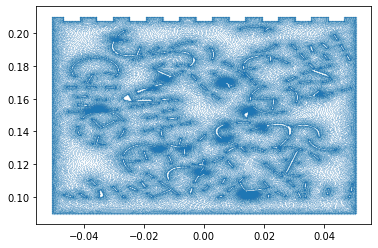

In [ ]:
plt.scatter(x,y,s=.01)
plt.show()

In [ ]:
vi = D['Velocity[i] (m/s)']
vj = D['Velocity[j] (m/s)']
len(vi), len(vj)

(150073, 150073)